##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 单词嵌入向量

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/text/word_embeddings" class="">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">     在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/word_embeddings.ipynb" class="">     <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" class="">     在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/word_embeddings.ipynb" class="">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" class="">     在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/text/word_embeddings.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

本教程将介绍单词嵌入向量。包含完整的代码，可在小型数据集上从头开始训练单词嵌入向量，并使用 [Embedding Projector](http://projector.tensorflow.org)（如下图所示）可视化这些嵌入向量。

<img alt="Screenshot of the embedding projector" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1">

## 用数字表示文本

机器学习模型将向量（数字数组）作为输入。在处理文本时，我们必须先想出一种策略，将字符串转换为数字（或将文本“向量化”），然后再其馈入模型。在本部分中，我们将探究实现这一目标的三种策略。

### 独热编码

作为第一个想法，我们可以对词汇表中的每个单词进行“独热”编码。考虑这样一句话：“The cat sat on the mat”。这句话中的词汇（或唯一单词）是（cat、mat、on、sat、the）。为了表示每个单词，我们将创建一个长度等于词汇量的零向量，然后在与该单词对应的索引中放置一个 1。下图显示了这种方法。

<img alt="Diagram of one-hot encodings" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/one-hot.png?raw=1">

为了创建一个包含句子编码的向量，我们可以将每个单词的独热向量连接起来。

要点：这种方法效率低下。一个独热编码向量十分稀疏（这意味着大多数索引为零）。假设我们的词汇表中有 10,000 个单词。为了对每个单词进行独热编码，我们将创建一个其中 99.99% 的元素都为零的向量。

### 用一个唯一的数字编码每个单词

我们可以尝试的第二种方法是使用唯一的数字来编码每个单词。继续上面的示例，我们可以将 1 分配给“cat”，将 2 分配给“mat”，依此类推。然后，我们可以将句子“The cat sat on the mat”编码为一个密集向量，例如 [5, 1, 4, 3, 5, 2]。这种方法是高效的。现在，我们有了一个密集向量（所有元素均已满），而不是稀疏向量。

但是，这种方法有两个缺点：

- 整数编码是任意的（它不会捕获单词之间的任何关系）。

- 对于要解释的模型而言，整数编码颇具挑战。例如，线性分类器针对每个特征学习一个权重。由于任何两个单词的相似性与其编码的相似性之间都没有关系，因此这种特征权重组合没有意义。

### 单词嵌入向量

单词嵌入向量为我们提供了一种使用高效、密集表示的方法，其中相似的单词具有相似的编码。重要的是，我们不必手动指定此编码。嵌入向量是浮点值的密集向量（向量的长度是您指定的参数）。它们是可以训练的参数（模型在训练过程中学习的权重，与模型学习密集层权重的方法相同），无需手动为嵌入向量指定值。8 维的单词嵌入向量（对于小型数据集）比较常见，而在处理大型数据集时最多可达 1024 维。维度更高的嵌入向量可以捕获单词之间的细粒度关系，但需要更多的数据来学习。

<img alt="Diagram of an embedding" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding2.png?raw=1">

上面是一个单词嵌入向量的示意图。每个单词都表示为浮点值的 4 维向量。还可以将嵌入向量视为“查找表”。学习完这些权重后，我们可以通过在表中查找对应的密集向量来编码每个单词。

## 设置

In [1]:
import tensorflow as tf

In [3]:
import os
from tensorflow import keras
from tensorflow.keras import layers
os.environ["https_proxy"] = "http://yikuni.com:52514"
os.environ["http_proxy"] = "http://yikuni.com:52514"
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## 使用嵌入向量层

Keras 让使用单词嵌入向量变得轻而易举。我们来看一下[嵌入向量](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Embedding)层。

可以将嵌入向量层理解为一个从整数索引（代表特定单词）映射到密集向量（其嵌入向量）的查找表。嵌入向量的维数（或宽度）是一个参数，您可以试验它的数值，以了解多少维度适合您的问题，这与您试验密集层中神经元数量的方式非常相似。


In [8]:
embedding_layer = layers.Embedding(1000, 5)

创建嵌入向量层时，嵌入向量的权重会随机初始化（就像其他任何层一样）。在训练过程中，通过反向传播来逐渐调整这些权重。训练后，学习到的单词嵌入向量将粗略地编码单词之间的相似性（因为它们是针对训练模型的特定问题而学习的）。

如果将整数传递给嵌入向量层，结果会将每个整数替换为嵌入向量表中的向量：

In [13]:
result = embedding_layer(tf.constant([1,2,3]))
result.numpy()

array([[ 3.1922627e-02,  2.1858905e-02, -1.4865328e-02,  2.4247233e-02,
        -4.2709399e-02],
       [-4.3408897e-02, -1.9830942e-02, -4.4986583e-02, -4.0383827e-02,
         2.4150435e-02],
       [ 8.5783824e-03,  5.8723316e-03, -3.8527928e-02,  3.6975887e-02,
        -1.4781952e-05]], dtype=float32)

对于文本或序列问题，嵌入向量层采用整数组成的 2D 张量，其形状为 `(samples, sequence_length)`，其中每个条目都是一个整数序列。它可以嵌入可变长度的序列。您可以在形状为 `(32, 10)`（32 个长度为 10 的序列组成的批次）或 `(64, 15)`（64 个长度为 15 的序列组成的批次）的批次上方馈入嵌入向量层。

返回的张量比输入多一个轴，嵌入向量沿新的最后一个轴对齐。向其传递 `(2, 3)` 输入批次，输出为 `(2, 3, N)`


In [14]:
result = embedding_layer(tf.constant([[0,1,2],[3,4,5]]))
result.shape

TensorShape([2, 3, 5])

当给定一个序列批次作为输入时，嵌入向量层将返回形状为 `(samples, sequence_length, embedding_dimensionality)` 的 3D 浮点张量。为了从可变长度的序列转换为固定表示，有多种标准方法。您可以先使用 RNN、注意力或池化层，然后再将其传递给密集层。本教程使用池化，因为它最简单。接下来，学习[使用 RNN 进行文本分类](text_classification_rnn.ipynb)教程是一个不错的选择。

## 从头开始学习嵌入向量

在本教程中，您将基于 IMDB 电影评论来训练情感分类器。在此过程中，模型将从头开始学习嵌入向量。我们将使用经过预处理的数据集。

要从头开始加载文本数据集，请参阅[加载文本教程](../load_data/text.ipynb)。

In [15]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

2023-08-27 16:12:46.758604: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "ABORTED: All 10 retry attempts failed. The last failure: Error executing an HTTP request: HTTP response code 500 with body 'dial tcp: lookup metadata.google.internal on 183.60.83.19:53: no such host
'".


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


获取编码器 (`tfds.features.text.SubwordTextEncoder`)，并快速浏览词汇表。

词汇表中的“_”代表空格。请注意词汇表如何包含完整单词（以“_”结尾）以及可用于构建更大单词的部分单词：

In [16]:
encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [46]:
print(info.features['text'])

Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>)


电影评论的长度可以不同。我们将使用 `padded_batch` 方法来标准化评论的长度。

In [22]:
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

导入时，评论的文本是整数编码的（每个整数代表词汇表中的特定单词或单词部分）。

请注意尾随零，因为批次会填充为最长的示例。

In [23]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

2023-08-27 17:15:27.468362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[  19, 3584,    9, ...,    0,    0,    0],
       [ 133,  244, 2140, ...,    0,    0,    0],
       [  12,   96,  202, ...,    0,    0,    0],
       ...,
       [2960, 5184, 2960, ...,    6,  283, 7970],
       [  19,   27, 7319, ...,    0,    0,    0],
       [  19,  294, 3175, ...,    0,    0,    0]])

### 创建一个简单模型

我们将使用 [Keras 序列式 API](../../guide/keras) 定义模型。在这种情况下，它是一个“连续词袋”样式的模型。

- 接下来，嵌入向量层将采用整数编码的词汇表，并查找每个单词索引的嵌入向量。在模型训练时会学习这些向量。向量会向输出数组添加维度。得到的维度为：`(batch, sequence, embedding)`。

- 接下来，通过对序列维度求平均值，GlobalAveragePooling1D 层会返回每个样本的固定长度输出向量。这让模型能够以最简单的方式处理可变长度的输入。

- 此固定长度输出向量通过一个包含 16 个隐藏单元的完全连接（密集）层进行流水线传输。

- 最后一层与单个输出节点密集连接。利用 Sigmoid 激活函数，得出此值是 0 到 1 之间的浮点数，表示评论为正面的概率（或置信度）。

小心：此模型不使用遮盖，而是使用零填充作为输入的一部分，因此填充长度可能会影响输出。要解决此问题，请参阅[遮盖和填充指南](../../guide/keras/masking_and_padding)。

In [24]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 16)          130960    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 131249 (512.69 KB)
Trainable params: 131249 (512.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 编译和训练模型

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 9s 3ms/step - loss: 0.5197 - accuracy: 0.6794 - val_loss: 0.3870 - val_accuracy: 0.8500
Epoch 2/10
  59/2500 [..............................] - ETA: 6s - loss: 0.3240 - accuracy: 0.8593

2023-08-27 17:15:56.179235: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.2911 - accuracy: 0.8800 - val_loss: 0.2683 - val_accuracy: 0.8900
Epoch 3/10
  58/2500 [..............................] - ETA: 6s - loss: 0.2643 - accuracy: 0.8931

2023-08-27 17:16:03.130100: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.2348 - accuracy: 0.9081 - val_loss: 0.3362 - val_accuracy: 0.8350
Epoch 4/10
  58/2500 [..............................] - ETA: 6s - loss: 0.2343 - accuracy: 0.9017

2023-08-27 17:16:10.001268: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.2030 - accuracy: 0.9212 - val_loss: 0.3672 - val_accuracy: 0.8550
Epoch 5/10
  57/2500 [..............................] - ETA: 6s - loss: 0.2030 - accuracy: 0.9158

2023-08-27 17:16:16.903474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1805 - accuracy: 0.9316 - val_loss: 0.3362 - val_accuracy: 0.8900
Epoch 6/10
  59/2500 [..............................] - ETA: 6s - loss: 0.1881 - accuracy: 0.9305

2023-08-27 17:16:23.858538: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1623 - accuracy: 0.9385 - val_loss: 0.4240 - val_accuracy: 0.8500
Epoch 7/10
  59/2500 [..............................] - ETA: 6s - loss: 0.1426 - accuracy: 0.9390

2023-08-27 17:16:30.761855: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1460 - accuracy: 0.9468 - val_loss: 0.4465 - val_accuracy: 0.8550
Epoch 8/10
  60/2500 [..............................] - ETA: 6s - loss: 0.1489 - accuracy: 0.9400

2023-08-27 17:16:37.601629: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1348 - accuracy: 0.9508 - val_loss: 0.3280 - val_accuracy: 0.8650
Epoch 9/10
  38/2500 [..............................] - ETA: 6s - loss: 0.1171 - accuracy: 0.9579

2023-08-27 17:16:44.452068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1234 - accuracy: 0.9565 - val_loss: 0.4463 - val_accuracy: 0.8700
Epoch 10/10
  60/2500 [..............................] - ETA: 6s - loss: 0.1006 - accuracy: 0.9583

2023-08-27 17:16:51.253886: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2500/2500 [==============================] - 7s 3ms/step - loss: 0.1121 - accuracy: 0.9606 - val_loss: 0.4532 - val_accuracy: 0.8500


2023-08-27 17:16:58.068147: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


通过这种方法，我们的模型可以达到约 88% 的验证准确率（请注意，该模型过度拟合，因此训练准确率要高得多）。

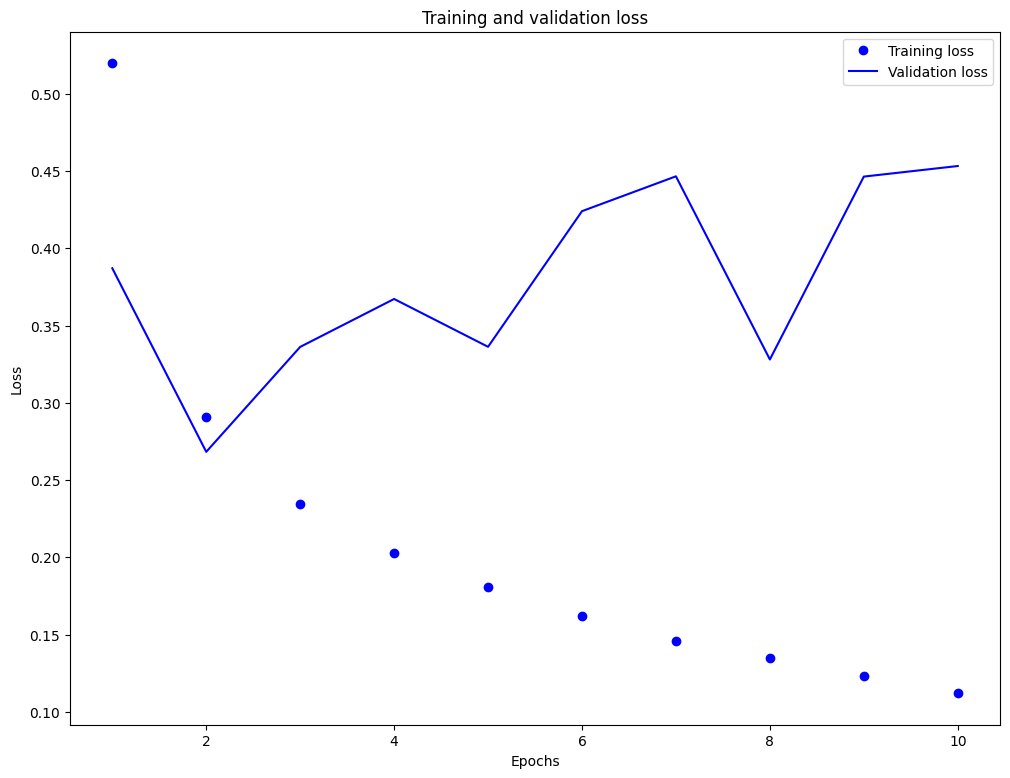

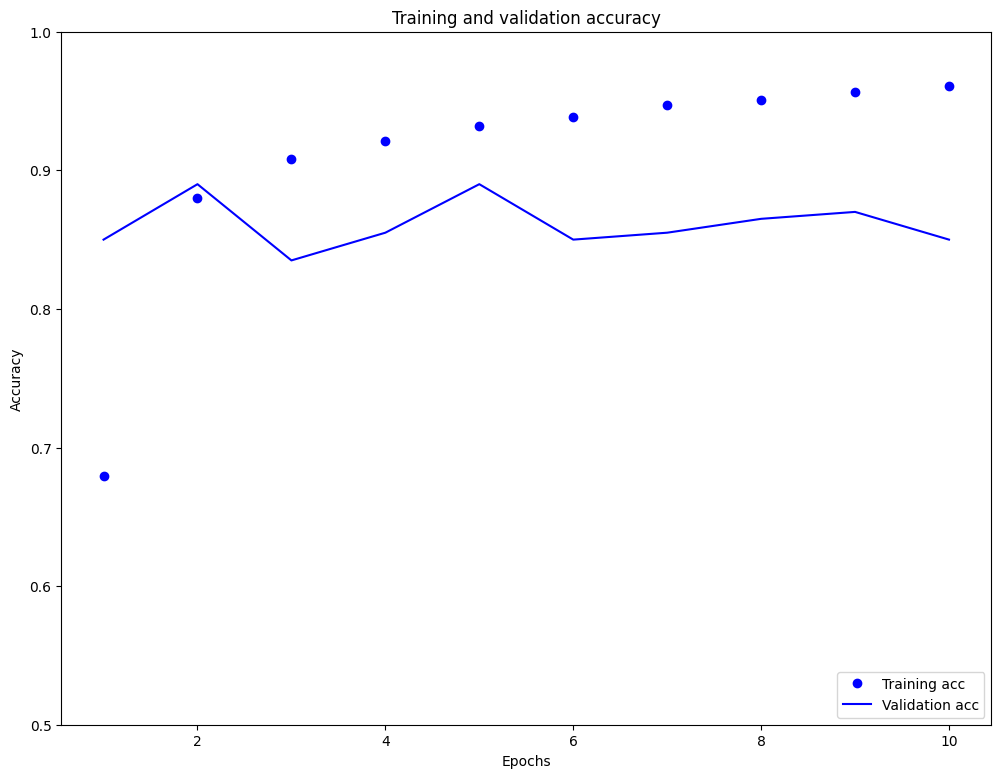

In [35]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

## 检索学习的嵌入向量

接下来，我们检索在训练期间学习的单词嵌入向量。这将是一个形状为 `(vocab_size, embedding-dimension)` 的矩阵。

In [36]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 16)


现在，我们将权重写入磁盘。要使用 [Embedding Projector](http://projector.tensorflow.org)，我们将以制表符分隔的格式上传两个文件：一个向量文件（包含嵌入向量）和一个元数据文件（包含单词）。

In [43]:
print(model.predict([[0, 1, 1]]))

1/1 [==============================] - 0s 56ms/step
[[16.825743]]


In [37]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

如果您正在 [Colaboratory](https://colab.research.google.com) 中运行本教程，则可以使用以下代码段将这些文件下载到本地计算机上（或使用文件浏览器，*View -> Table of contents -> File browser*）。

In [16]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## 可视化嵌入向量

为了可视化嵌入向量，我们将它们上传到 Embedding Projector。

打开 [Embedding Projector](http://projector.tensorflow.org/)（也可以在本地 TensorBoard 实例中运行）。

- 点击“Load data”。

- 上传我们在上面创建的两个文件：`vecs.tsv` 和 `meta.tsv`。

现在将显示您已训练的嵌入向量。您可以搜索单词以查找其最邻近。例如，尝试搜索“beautiful”，您可能会看到“wonderful”等相邻单词。

注：您的结果可能会略有不同，具体取决于训练嵌入向量层之前如何随机初始化权重。

注：您可以试验性地使用更简单的模型来生成更多可解释的嵌入向量。尝试删除 `Dense(16)` 层，重新训练模型，然后再次可视化嵌入向量。

<img alt="Screenshot of the embedding projector" width="400" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/images/embedding.jpg?raw=1">


## 后续步骤


本教程向您展示了如何在小数据集上从头开始训练和可视化单词嵌入向量。

- 要了解循环网络，请参阅 [Keras RNN 指南](../../guide/keras/rnn.ipynb)。

- 要详细了解文本分类（包括整个工作流，以及如果您对何时使用嵌入向量还是独热编码感到好奇），我们建议您阅读这篇实用的文本分类[指南](https://developers.google.com/machine-learning/guides/text-classification/step-2-5)。